In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = 'data/tmdb-movies.csv'

imported_data = pd.read_csv(data)

In [2]:
imported_data.shape

(10866, 21)

# Introduction
## Description of Dataset
I selected The Movie Database dataset from Kaggle for my project.  The dataset was created after IMDB requested a takedown of their data from Kaggle.  As a consequence, an open-source alternative was selected with the caveat that there were some open questions about the data:
* The currency of the budget amounts is not known.
* The revenue might not consistently show global revenues.
* The dataset, as a whole, has not undergone quality auditing.
    * There are 0s for numerous budget & revenue records.  It is recommended that 0s are treated as missing values for these records.
    * Though not mentioned, because The Movie Database is a publicly curated dataset, it is subject to similar hesitations that other public, user-written databases are.  The database is not necessarily peer-reviewed or sourced for accuracy.
    
With these caveats in mind, I decided to review the dataset to look at the general character of the data, as well as perform some experimental cleaning functions.  The first question of interest to me is the scope of the movies in the dataset; what is the timespan of movies included, and how many are there?

In [3]:
imported_data['release_year'].agg(['min', 'max'])

min    1960
max    2015
Name: release_year, dtype: int64

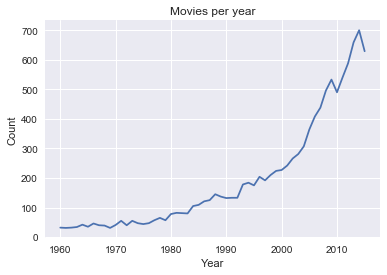

In [4]:
counts_by_year = imported_data.groupby('release_year')['id'].count()

plt.plot(counts_by_year)
plt.title('Movies per year')
plt.xlabel('Year')
plt.ylabel('Count')

We can see that the first movie included in the database is from 1960, and the latest is 2015; movies included seems to grow year-over-year on a seemingly logarithmic scale.  One might suppose this is because the more recent a movie is, the more likely a user is contribute meaningfully to information about it.  Similarly, it could be the case that more movies are actually produced as time goes on.  Meaningfully answering these questions would require juxtaposing the dataset against other data -- performing the quality assessment precluded in the Kaggle description -- as well as more rigorous statistical testing than a line chart.

Interestingly, there are a few noticeable dips in movies per year.  An immediate one of note is in 2010, possibly a consequence of a [notable writer's strike](https://en.wikipedia.org/wiki/2007%E2%80%9308_Writers_Guild_of_America_strike).  The strike occurred from late 2007 and into early 2008, and might account for the dip in movies.

In [5]:
imported_data.query('release_year >= 2006 and release_year <= 2012').groupby('release_year')['id'].count()

release_year
2006    408
2007    438
2008    496
2009    533
2010    490
2011    540
2012    588
Name: id, dtype: int64

More information would be helpful to contextualize this fact of the data.  Notably, it might be helpful to know the standard production time of a movie -- to know when a movie being written, then optioned, is released theatrically!  I'm sure there are many confounding variables beyond the scope of this dataset and investigation, but nonetheless it is an interesting point to speculate on.

## Wrangling and Cleaning

One of my goals for this dataset is understanding what exactly is included, and experimenting with teasing out interesting questions that it might contribute to answering.  To that end, I'll be looking at some of the standard techniques for assessing data:
* Looking at the first and last 5 rows
* getting a sense of how many values are missing
* dropping some attributes that might not help with an analysis, either because they are poorly formatted, missing data, or require advanced techniques such as sentiment analysis.

This dataset seems to be structured as a table; that is, it contains no strange artifacts after the end of the dataset that would complicate an analysis.  From a high-level view, it looks like the beginning and end of the data have appropriate values for each field.

In [8]:
imported_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

On the other hand, there are several fields that are missing values.  Furthermore, I know from the description of the dataset that the revenue and budget attributes ('budget', 'revenue', 'budget_adj', 'revenue_adj') contain 0 values that should be treated as missing rather than actual 0 values.

For the fields missing many values, I want to spot check the kind of information contained to see if it seems important.  I particularly will be looking at the following:
* 'homepage'
* 'tagline'
* 'keywords'
* 'production_companies'

OK, so those values make sense for these attributes, but they don't really seem helpful to my goals.  Maybe the homepages would be interesting if I were interested in having seeds for a web crawler, or the taglines to run through a natural language analysis -- maybe something to correlate sentiment to viewership.  The keywords are too sporadic and unstructured to be particularly helpful, I would think.

I'm going to drop these attributes from my dataframe.  It'd probably be OK to leave them there and ignore then, but why keep them in memory if I don't have to?

In [13]:
imported_data.drop(['homepage', 'tagline', 'keywords', 'production_companies'], axis=1, inplace=True)
imported_data.drop_duplicates(inplace=True)

In [14]:
imported_data.shape

(10865, 17)

Awesome!  Now, another thing I noticed about is that the release year isn't exactly helpful, so I want to change it to a datetime object in case I end up needing to do anything with the date.

In [15]:
from datetime import datetime

def change_to_date(date_string):
    return datetime.strptime(date_string, "%m/%d/%y")

imported_data['release_date'] = imported_data['release_date'].apply(change_to_date)

There we go; that seems to be a good start.  There are some annoying facts about the data -- like that 'cast' and 'genres' are stored as pipe-delimited values.  That seems extremely unnecessary, but I'm not the architect, so I'll refrain from further judgment at this time.

Spoiler alert: this does end up causing me a lot of frustration, especially because of how Pandas interacts with strings.

# Exploring the Data

An easy way to start exploring data is to look at some correlations.  We can't make any statistical inferences from scatterplots alone, but we might see that data trends in a particular way.  I'll start by looking at the relationship between the number of votes, and the average rating.  Maybe we'll see a common adage, "people are more likely to express an opinion for something they dislike."

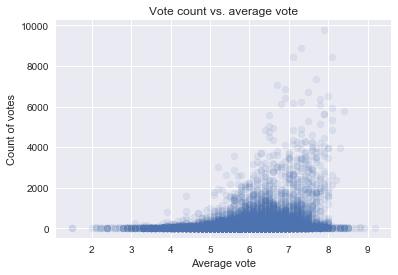

In [48]:
vote_counts = imported_data['vote_count']
vote_averages = imported_data['vote_average']

plt.scatter(vote_averages, vote_counts, alpha=0.1)
plt.title("Vote count vs. average vote")
plt.xlabel("Average vote")
plt.ylabel("Count of votes")

Whoa!  There's a lot of records hovering at an extremely low number of votes.  You can almost claim a positive correlation between the count and average score, but I'm extremely hesitant to do so since so many entries 

In [18]:
low_votes = len(imported_data.query('vote_count < 100'))
high_votes = len(imported_data.query('vote_count >= 100'))
low_votes, high_votes, low_votes/len(imported_data)

(7537, 3328, 0.6936953520478601)

In [19]:
len(imported_data.query('vote_count <= 10'))/len(imported_data)

0.0461113667740451

Interesting.  Almost 70% of the movies have less than 100 votes.  It's hard to define what might even be considered an outlier with such a density of low votes.  5% of the movies have 10 or less votes!  I wonder what the distribution of ratings looks like...

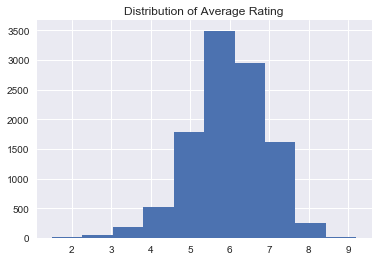

In [20]:
plt.hist(vote_averages)
plt.title('Distribution of Average Rating')

Maybe unsurprisingly, the distribution seems to match the general count of votes.  At least the averages are normally distributed.

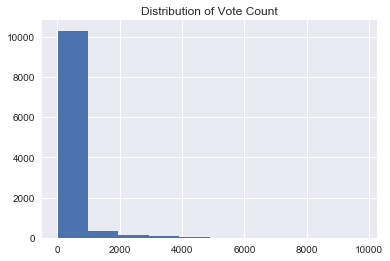

In [21]:
plt.hist(vote_counts)
plt.title('Distribution of Vote Count')

The distribution of vote counts, on the other hand, is so extremely right skewed I wonder if it's even usable as a datapoint.

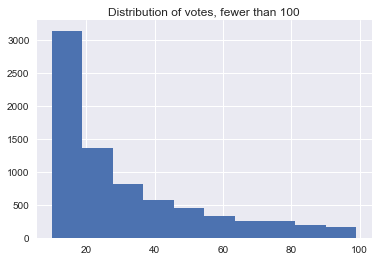

In [22]:
vote_counts_less_than_100 = imported_data.query('vote_count < 100')['vote_count']

plt.hist(vote_counts_less_than_100)
plt.title('Distribution of votes, fewer than 100')

We can see that the distribution is the same when only considering records with fewer than 100 votes.  We could probably keep drilling down, but I'm not sure that would be a productive exercise.

Instead, let's look at some of the other data points, like whether the budget has any impact on the rating.

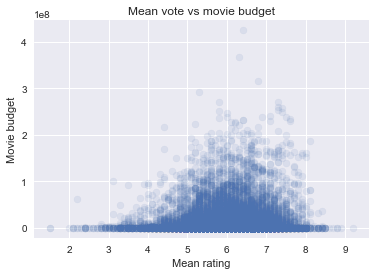

In [49]:
budgets = imported_data['budget_adj']

plt.scatter(vote_averages, budgets, alpha=0.1)
plt.title("Mean vote vs movie budget")
plt.xlabel("Mean rating")
plt.ylabel("Movie budget")

Yikes!  We can see that this value is similarly clustered around a low budget.

In [24]:
imported_data['budget_adj'].agg(['min', 'max'])

min            0.0
max    425000000.0
Name: budget_adj, dtype: float64

OK, let's remove the 0 values from the budget, which is something we know should be discounted from the description of the data.

In [25]:
budget_df = imported_data[['budget_adj', 'vote_average']].query('budget_adj != 0')
budget_df['budget_adj'].agg(['min', 'max'])

min    9.210911e-01
max    4.250000e+08
Name: budget_adj, dtype: float64

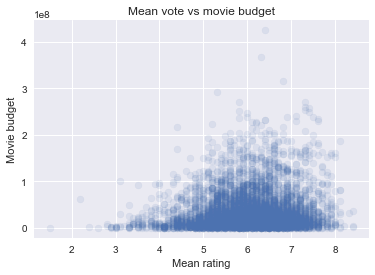

In [50]:
budgets = budget_df['budget_adj']
vote_averages = budget_df['vote_average']

plt.scatter(vote_averages, budgets, alpha=0.1)
plt.title("Mean vote vs movie budget")
plt.xlabel("Mean rating")
plt.ylabel("Movie budget")

Interestingly, the shape of this scatterplot doesn't seem to significantly change. I wonder if these numerical data are useful in the context of an analysis.

Perhaps it's best to switch tactics. Let's take a look at the genres included for each movie, to get a sense of how commonly a label is applied to a movie. I'm sure it's a simple matter to split a series in Pandas to aggregate a count of each value after splitting the value of each cell.

Ha, ha! Just kidding. This exercise was actually one of the more painful things I've ever tried to do with Pandas, because I didn't notice in my earlier, initial review of the DataFrame's non-null counts that this field included some null values. This missed detail led me down a strange journey through a rabbit hole with stops along way including opening a ticket about a bug in the Pandas library¹.

Finally, after much wrestling with the internal structure and a consideration of reloading the file using an entirely different library, I found that the issue was null values in the 'genres' field. After dropping them, I was able to easily iterate through the values and count the frequency of each genre keyword.

¹ Although the flaw was my own understanding of the dataset, it's a confusing behavior that the datatype of the missing strings defaulted to float; in my counting loop below, I kept tripping a type error because floats don't have a split method. This implementation detail would be a good research topic about Pandas to learn the library more intimately.

In [45]:
bad_genres = imported_data[imported_data['genres'].apply(type) != type(imported_data['genres'].iloc[0])]['genres']
print(len(bad_genres))
bad_genres.value_counts()

23


Series([], Name: genres, dtype: int64)

In [46]:
genres = imported_data['genres'].dropna().iteritems()
genre_counts = {}

for _, row in genres:
    for v in row.split('|'):
        if v not in genre_counts.keys():
            genre_counts[v] = 1
        else:
            genre_counts[v] += 1

Finally, let's make a bar chart to compare the relative frequencies of the genres, now that we've aggregated the totals from the 'genres' series.

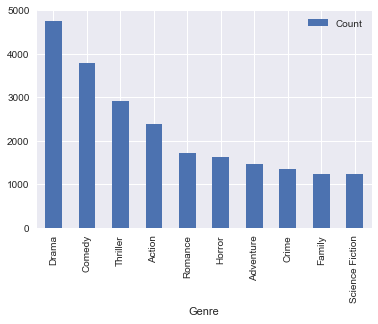

In [47]:
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])

genre_counts_df.set_index('Genre').nlargest(10, 'Count').plot.bar()

Interesting.  It looks like the most movies are tagged as dramas.  Not to overemphasize my own struggle, but that seems like an appropriate end to my own exploration.  Certainly, I felt my struggle with making this simple chart a dramatic struggle worthy of a Greek playwright.